In [ ]:
%reload_ext autoreload
%autoreload 2 
%matplotlib inline  

In [ ]:
import os
from fastai import *
from fastai.vision import *

In [ ]:
os.listdir("../input/chest-xray-pneumonia")

['chest_xray']

In [ ]:
#specifying the path of the dataset 
path = Path("../input/chest-xray-pneumonia")
dest = path   
#any missing parents of this path are created as needed if parents = True  
dest.mkdir(parents=True, exist_ok=True)   

In [ ]:
path.ls()

[PosixPath('../input/chest-xray-pneumonia/chest_xray')]

In [ ]:
#the classes are defined  
classes = ['healthy', 'pneumonia'] 

In [ ]:
#applying transformations to all the images 
tfms = get_transforms(pad(padding=50, mode='border'),
                      max_lighting=0.25, 
                      flip_vert=False,
                      max_zoom=0.1)

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path,bs = 32, train=".", valid_pct=0.3,
        ds_tfms=tfms, size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
#printing the number of classes
data.classes 

['NORMAL', 'PNEUMONIA']

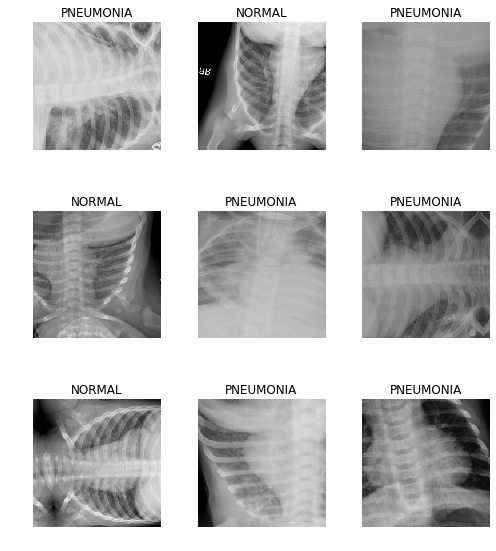

In [ ]:
#displaying the images in 3 rows
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
#displaying the classes
data.classes, data.c 

(['NORMAL', 'PNEUMONIA'], 2)

In [ ]:
#displaying the length of the training and validation datasets
len(data.train_ds), len(data.valid_ds)

(8199, 3513)

In [ ]:
#using resnet 101 architecture  
arch = models.resnet101 

In [ ]:
def fit_with(wd,dp,moms):
    
    # Create the model using a specified dropout and weight decay
    learn = cnn_learner(data, arch, pretrained = True, ps=dp, wd=wd, model_dir="/tmp/model/", loss_func = nn.CrossEntropyLoss(), metrics=[accuracy, error_rate, AUROC()])      
    
    
    # Train the model for a specified number of epochs using a specified max learning rate
    learn.fit_one_cycle(10, moms=moms)
    
    # Plot the loss over time
    learn.recorder.plot_losses()
    
    # Save, print, and return the model's accuracy
    acc = float(learn.validate(learn.data.valid_dl)[1]) 
    
    print("Accuracy:" + str(acc*100))
    
    # The small change: we're only going to return the accuracy
    
    return acc   

Accuracy:97.15343117713928
|  4        |  0.9715   |  0.1      |  0.1      |  0.4      |
Iteration 0: 
	{'target': 0.9672644734382629, 'params': {'dp': 0.2668088018810296, 'moms': 0.0986016224672108, 'wd': 0.00014573848945622018}}
Iteration 1: 
	{'target': 0.9746655225753784, 'params': {'dp': 0.22093302905273593, 'moms': 0.09573377945408557, 'wd': 0.037026204048042244}}
Iteration 2: 
	{'target': 0.9672644734382629, 'params': {'dp': 0.5, 'moms': 0.095, 'wd': 0.4}}
Iteration 3: 
	{'target': 0.9715343117713928, 'params': {'dp': 0.1, 'moms': 0.1, 'wd': 0.4}}
{'target': 0.9746655225753784, 'params': {'dp': 0.22093302905273593, 'moms': 0.09573377945408557, 'wd': 0.037026204048042244}}


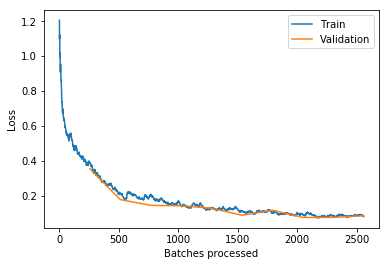

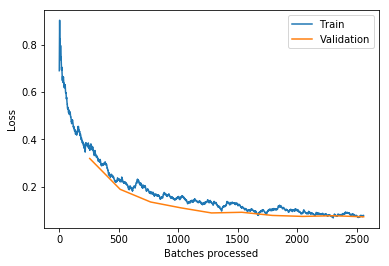

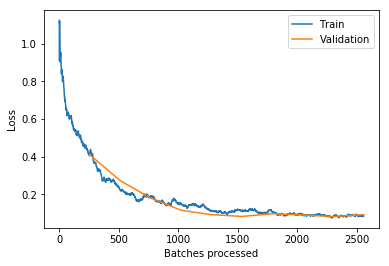

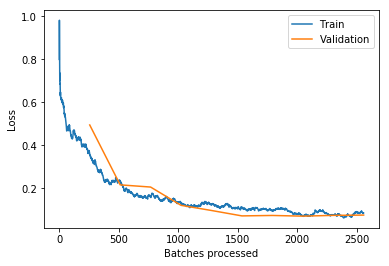

In [ ]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'wd':(1e-4,0.4), 'dp':(0.1,0.5), 'moms':(0.095,0.1)}

optimizer = BayesianOptimization(
    f=fit_with,
    pbounds=pbounds,
    verbose=2,   
    random_state=1,
) 

optimizer.maximize(init_points=2, n_iter=2,)

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)         

In [ ]:
wd =  0.037026204048042244  
dp = 0.22093302905273593
learn2 = cnn_learner(data, arch, pretrained = True, ps=dp, wd=wd, model_dir="/tmp/model/", loss_func = nn.CrossEntropyLoss(), metrics=[accuracy, error_rate, AUROC()])   
# Train the model for a specified number of epochs using a specified max learning rate
learn2.fit_one_cycle(10,moms = 0.09573377945408557)                        

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:08<00:00, 20.0MB/s] 


epoch,train_loss,valid_loss,accuracy,error_rate,auroc,time
0,0.347217,0.259586,0.931398,0.068602,0.979249,07:46
1,0.187950,0.148485,0.951324,0.048676,0.988605,07:41
2,0.162252,0.106693,0.968118,0.031882,0.992555,07:41
3,0.111128,0.089631,0.965841,0.034159,0.995153,07:43
4,0.094737,0.067684,0.974381,0.025619,0.996317,07:44
5,0.095931,0.073024,0.974950,0.025050,0.996956,07:45
6,0.070360,0.048527,0.980359,0.019641,0.997968,07:49
7,0.058914,0.046603,0.984059,0.015941,0.998164,07:50
8,0.052887,0.045924,0.982636,0.017364,0.998506,07:50
9,0.052583,0.045553,0.982636,0.017364,0.998491,07:52


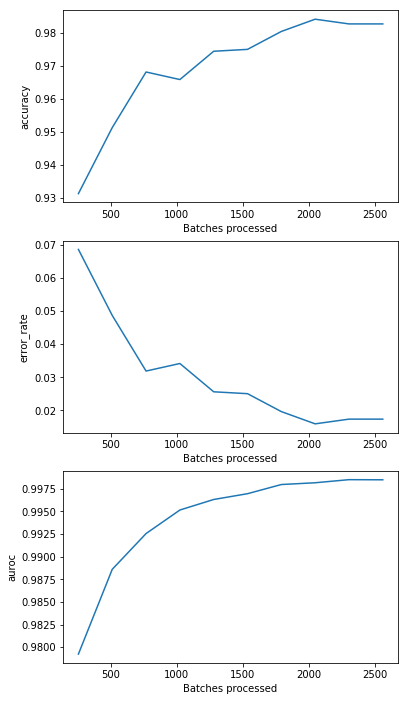

In [ ]:
learn2.recorder.plot_metrics()  

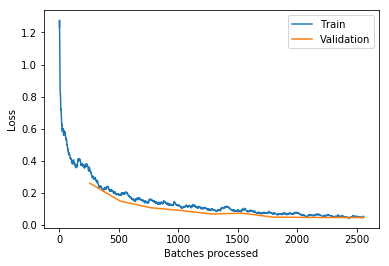

In [ ]:
learn2.recorder.plot_losses()

In [ ]:
learn2.lr_find(stop_div=False, num_it=200)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 7.59E-02
Min loss divided by 10: 5.25E-08


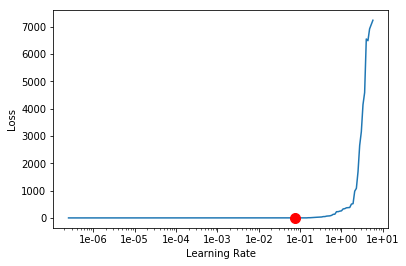

In [ ]:
learn2.recorder.plot(suggestion=True)

In [ ]:
min_grad_lr = learn2.recorder.min_grad_lr
min_grad_lr 

0.07585775750291834

In [ ]:
#unfreezing the layers which don't contain BatchNorm 
learn2.unfreeze() 

In [ ]:
#training the classifier with different learning rates
learn2.fit_one_cycle(10, slice(1e-3,1e-1))            

epoch,train_loss,valid_loss,accuracy,error_rate,auroc,time
0,0.151262,1.462433,0.678053,0.321947,0.989230,07:46
1,0.270695,0.196286,0.962995,0.037005,0.989865,07:50
2,0.735882,0.448146,0.929120,0.070880,0.977718,07:49
3,0.280917,0.370239,0.925705,0.074295,0.991073,07:57
4,0.278887,0.306772,0.946769,0.053231,0.994498,07:47
5,0.133270,0.081659,0.972673,0.027327,0.994960,07:42
6,0.131673,0.158501,0.958725,0.041275,0.995756,07:43
7,0.098964,0.086960,0.967834,0.032166,0.997736,07:41
8,0.076446,0.042907,0.986052,0.013948,0.998232,07:43
9,0.064874,0.041652,0.985198,0.014802,0.998340,07:44


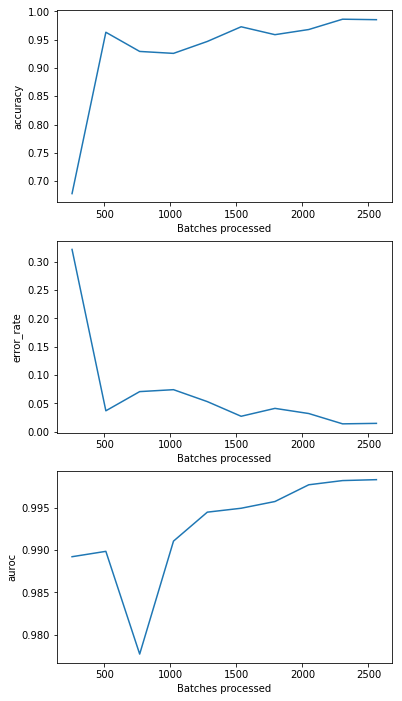

In [ ]:
#plotting the graph of metrics and losses 
learn2.recorder.plot_metrics()

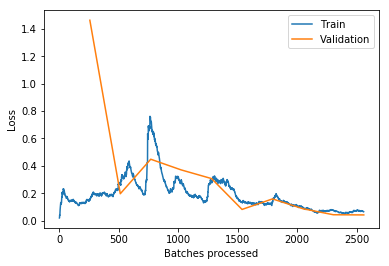

In [ ]:
learn2.recorder.plot_losses() 

In [ ]:
#classification interpretation contains the information about the model and the data
interp = ClassificationInterpretation.from_learner(learn2) 

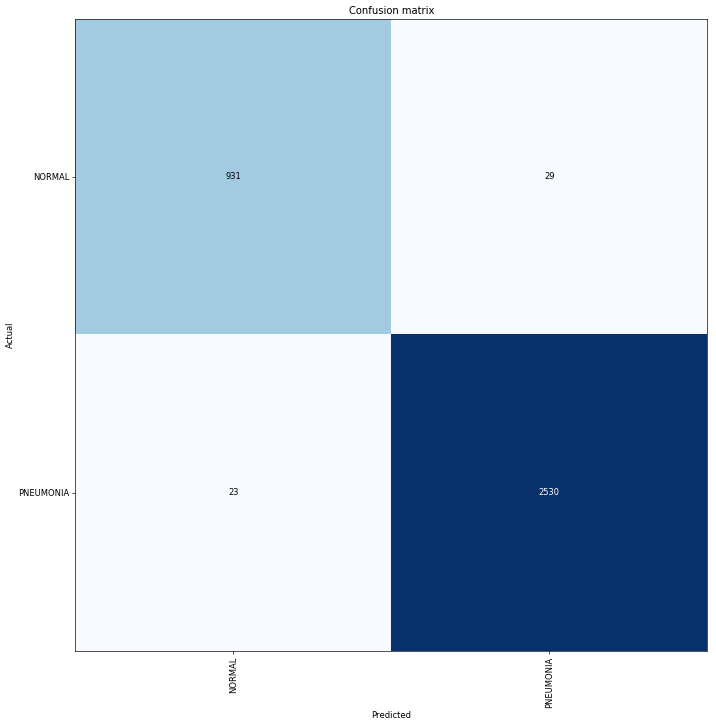

In [ ]:
#plotting the confusion matrix
interp.plot_confusion_matrix(figsize = (12,12), dpi = 60) 

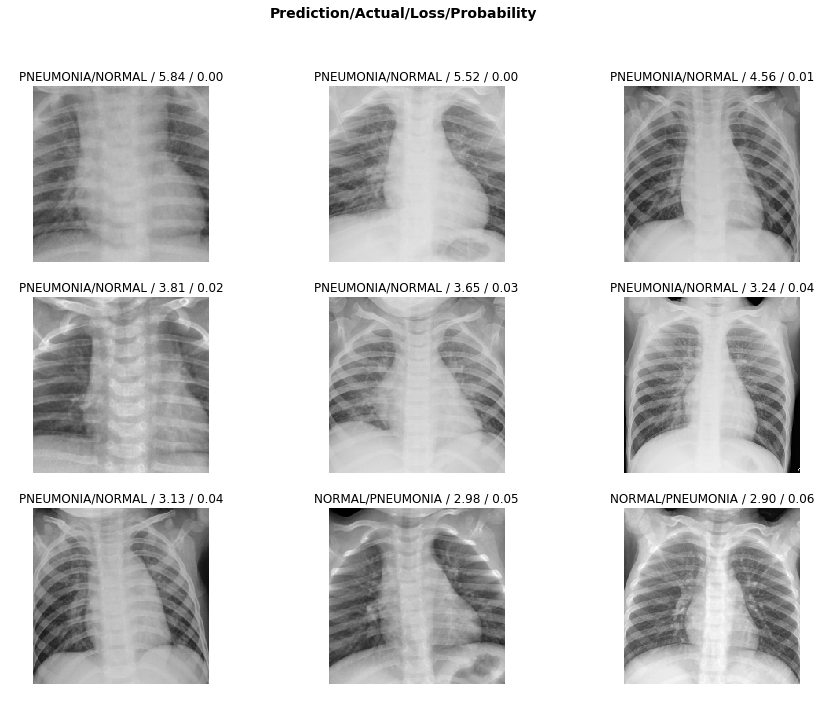

In [ ]:
#plotting the top losses
interp.plot_top_losses(9, figsize = (15,11)) 

In [ ]:
#most wrongly predicted images 
interp.most_confused(min_val = 10) 

[('NORMAL', 'PNEUMONIA', 29), ('PNEUMONIA', 'NORMAL', 23)]

In [ ]:
#model summary
learn2.summary()  

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     True      
___________________________________________________

In [ ]:
#evaluating the model
m = learn2.model.eval()

In [ ]:
#convulutional part of the model
m[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Category PNEUMONIA

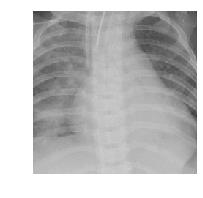

In [ ]:
#indexing the image for producing the heatmap
idx=1
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [ ]:
#data.one_item creates a minibatch which is xb here
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [ ]:
#grabbing m[0] and hook its output
def hooked_backward(cat=y):
    #context manager which removes the hook in the end of th block
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
#acts is taken from hook which hooks into the fwd pass 
#displaying the output hooks
acts  = hook_a.stored[0].cpu()
acts.shape 

torch.Size([2048, 7, 7])

In [ ]:
#taking the average of the acts 
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [ ]:
#function to display the heatmap
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
#alpha is the transperancy
#expand it to 352,352
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
              interpolation='gaussian', cmap='magma'); 

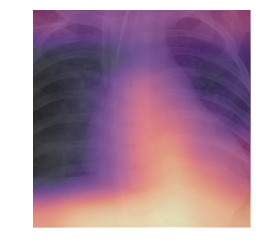

In [ ]:
#displaying the heat map 
show_heatmap(avg_acts) 